# PySlice Core Features: Lines and Planes in Parameter Space

This example covers the core features of the `PySlice` library, which provides tools for analyzing loss landscapes through different slicing strategies. We'll demonstrate how to evaluate a model's loss function along lines and planes in parameter space to produce visualizations of the loss landscape.

The PySlice library offers three main slicing strategies:
- **Linear Interpolation**: Evaluates loss along straight lines between two points in parameter space
- **Axis-Parallel Slicing**: Varies each parameter independently while keeping others fixed
- **Random Direction Slicing**: Explores loss landscapes along randomly chosen directions

This notebook demonstrates these techniques using both simple analytical functions and neural networks.

In [40]:
# Standard libraries
import copy
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.datasets as datasets
from tqdm import tqdm

# Set matplotlib parameters for better plots
matplotlib.rcParams['figure.figsize'] = [18, 12]

# PySlice library components
from pysclice.slicers import LinearInterpolationSlicer, AxisParallelSlicer, RandomDirectionSlicer
from pysclice.core import ModelWrapper
from pysclice.visualization import (
    plot_slices, 
    plot_linear_interpolation_enhanced,
    plot_2d_loss_landscape_enhanced,
    plot_multi_focus_parameter_slices,
    plot_neural_network_analysis
)

# Example models
from example_models import Simple2DParabola, MultiParameterQuadratic, create_dummy_data, identity_loss

In [41]:
# Slicing hyperparameters
SLICING_STEPS = 40          # Resolution for contour plots
LINEAR_SAMPLES = 50         # Number of samples for linear interpolation
PARAM_RANGE = 4.0          # Range for parameter exploration
NEURAL_NET_EPOCHS = 25     # Training epochs for neural network example

# Display settings
CONTOUR_LEVELS = 30        # Number of contour levels in plots

## 1. Preliminary: Working with Analytical Functions

This notebook demonstrates PySlice capabilities using both analytical functions and neural networks. We start with analytical functions because they have known properties, making it easy to verify that our slicing algorithms work correctly.

The cells in this section are specific to PySlice and show how to wrap models for loss landscape analysis.

In [42]:
# Create a 2D parabolic function f(x,y) = x² + y²
# This creates a bowl-shaped landscape with minimum at (0,0)
model_2d = Simple2DParabola(initial_x=1.5, initial_y=1.0)
dummy_inputs, dummy_targets = create_dummy_data()

# Wrap the model with PySlice's ModelWrapper
model_wrapper_2d = ModelWrapper(
    model=model_2d,
    loss_fn=identity_loss,
    train_data=(dummy_inputs, dummy_targets)
)

print(f"Created 2D parabola model: f(x,y) = x² + y²")
print(f"Initial parameters: x={model_2d.param1.item():.2f}, y={model_2d.param2.item():.2f}")
print(f"Initial loss: {model_wrapper_2d.compute_loss():.4f}")

# Also create a multi-parameter model for axis-parallel demonstrations
model_multi = MultiParameterQuadratic()
model_wrapper_multi = ModelWrapper(
    model=model_multi,
    loss_fn=identity_loss,
    train_data=(dummy_inputs, dummy_targets)
)

print(f"\nCreated multi-parameter model with {len(model_wrapper_multi.get_parameters())} parameters")
print(f"Expected minima at: {model_multi.get_expected_minima()}")

Created 2D parabola model: f(x,y) = x² + y²
Initial parameters: x=1.50, y=1.00
Initial loss: 3.2500

Created multi-parameter model with 5 parameters
Expected minima at: [0.0, 1.0, 0.0, -2.0, 0.0]


## 2. Points in Parameter Space

The state of a model represents a point in parameter space. PySlice works by evaluating the loss function at different points to understand the landscape structure. We can store interesting points for later analysis.

For analytical functions, we can easily define meaningful reference points:

In [43]:
# Define several interesting points in parameter space
point_minimum = np.array([0.0, 0.0])          # Global minimum
point_current = model_wrapper_2d.get_parameters()  # Current model state
point_high_loss = np.array([2.0, -2.0])       # A high-loss region

print("Reference points in parameter space:")
print(f"Minimum point: {point_minimum} (expected loss: {np.sum(point_minimum**2):.1f})")
print(f"Current point: {point_current} (actual loss: {model_wrapper_2d.compute_loss():.4f})")
print(f"High-loss point: {point_high_loss} (expected loss: {np.sum(point_high_loss**2):.1f})")

# Store current model state
model_initial = copy.deepcopy(model_2d)

# Create a "trained" state by moving closer to minimum
model_2d.param1.data = torch.tensor([0.2])
model_2d.param2.data = torch.tensor([0.1])
point_trained = model_wrapper_2d.get_parameters()

print(f"\nMoved model closer to minimum: {point_trained} (loss: {model_wrapper_2d.compute_loss():.4f})")

Reference points in parameter space:
Minimum point: [0. 0.] (expected loss: 0.0)
Current point: [1.5 1. ] (actual loss: 3.2500)
High-loss point: [ 2. -2.] (expected loss: 8.0)

Moved model closer to minimum: [0.2 0.1] (loss: 0.0500)


## 3. Linear Interpolations of Loss between Two Points

Linear interpolation slicing evaluates the loss at equidistant points along a straight line connecting two points in parameter space. This helps understand the smoothness and structure of the loss landscape along specific paths.

PySlice's `LinearInterpolationSlicer` makes this straightforward:

In [44]:
# Create linear interpolation slicer
linear_slicer = LinearInterpolationSlicer(model_wrapper_2d)

# Slice between current position and minimum
slice_data = linear_slicer.slice(
    start_point=point_current,
    end_point=point_minimum,
    n_samples=LINEAR_SAMPLES
)

# Extract the loss data
samples = slice_data['samples']
alphas = np.array([sample[0] for sample in samples])
losses = np.array([sample[1] for sample in samples])

print(f"Linear interpolation completed!")
print(f"Samples: {len(samples)}")
print(f"Loss range: {np.min(losses):.4f} to {np.max(losses):.4f}")

# Verify against analytical solution
# For parabola f(x,y) = x² + y², the path is p(α) = (1-α)*start + α*end
expected_params = np.array([(1-alpha)*point_current + alpha*point_minimum for alpha in alphas])
expected_losses = np.array([p[0]**2 + p[1]**2 for p in expected_params])

max_error = np.max(np.abs(losses - expected_losses))
print(f"Maximum error vs analytical solution: {max_error:.8f}")

Linear interpolation completed!
Samples: 50
Loss range: 0.0003 to 7.3125
Maximum error vs analytical solution: 0.00000053


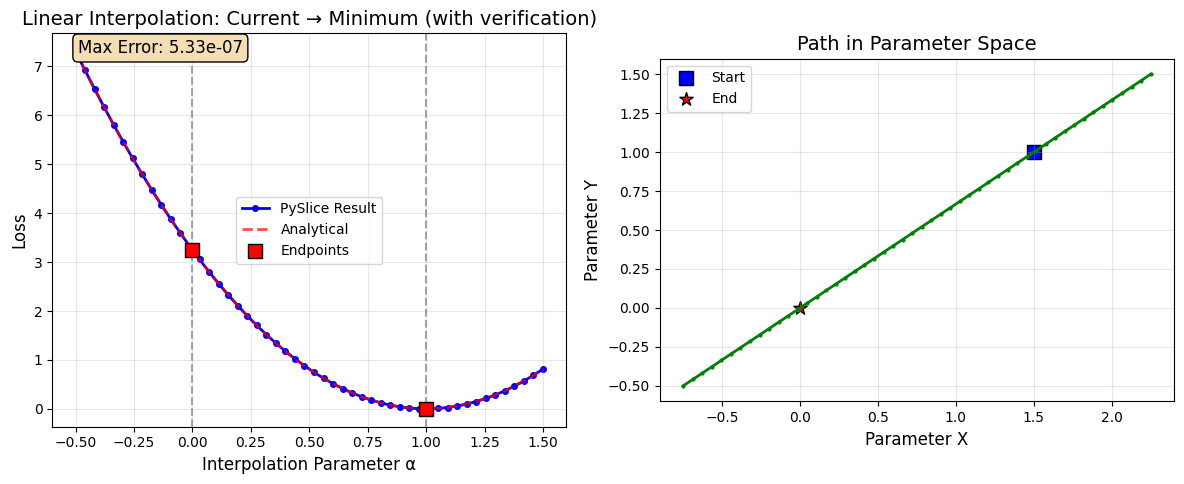

In [45]:
# Plot the linear interpolation results using enhanced visualization
# Calculate analytical solution for verification
expected_params = np.array([(1-alpha)*point_current + alpha*point_minimum for alpha in alphas])
expected_losses = np.array([p[0]**2 + p[1]**2 for p in expected_params])

# Create enhanced plot with analytical verification
fig = plot_linear_interpolation_enhanced(
    slice_data=slice_data,
    analytical_losses=expected_losses,
    title="Linear Interpolation: Current → Minimum (with verification)",
    figsize=(12, 5)
)
plt.show()

## 4. Axis-Parallel Slicing: Parameter-wise Analysis

Axis-parallel slicing varies each parameter independently while keeping all others fixed. This reveals how individual parameters contribute to the loss function and helps identify the most sensitive parameters.

Focus point slicing completed!
Center point: [ 1.  -0.5  0.   2.  -1. ]
Number of focus points: 50
Sampling method: lhs
Sampling radius: 1.5


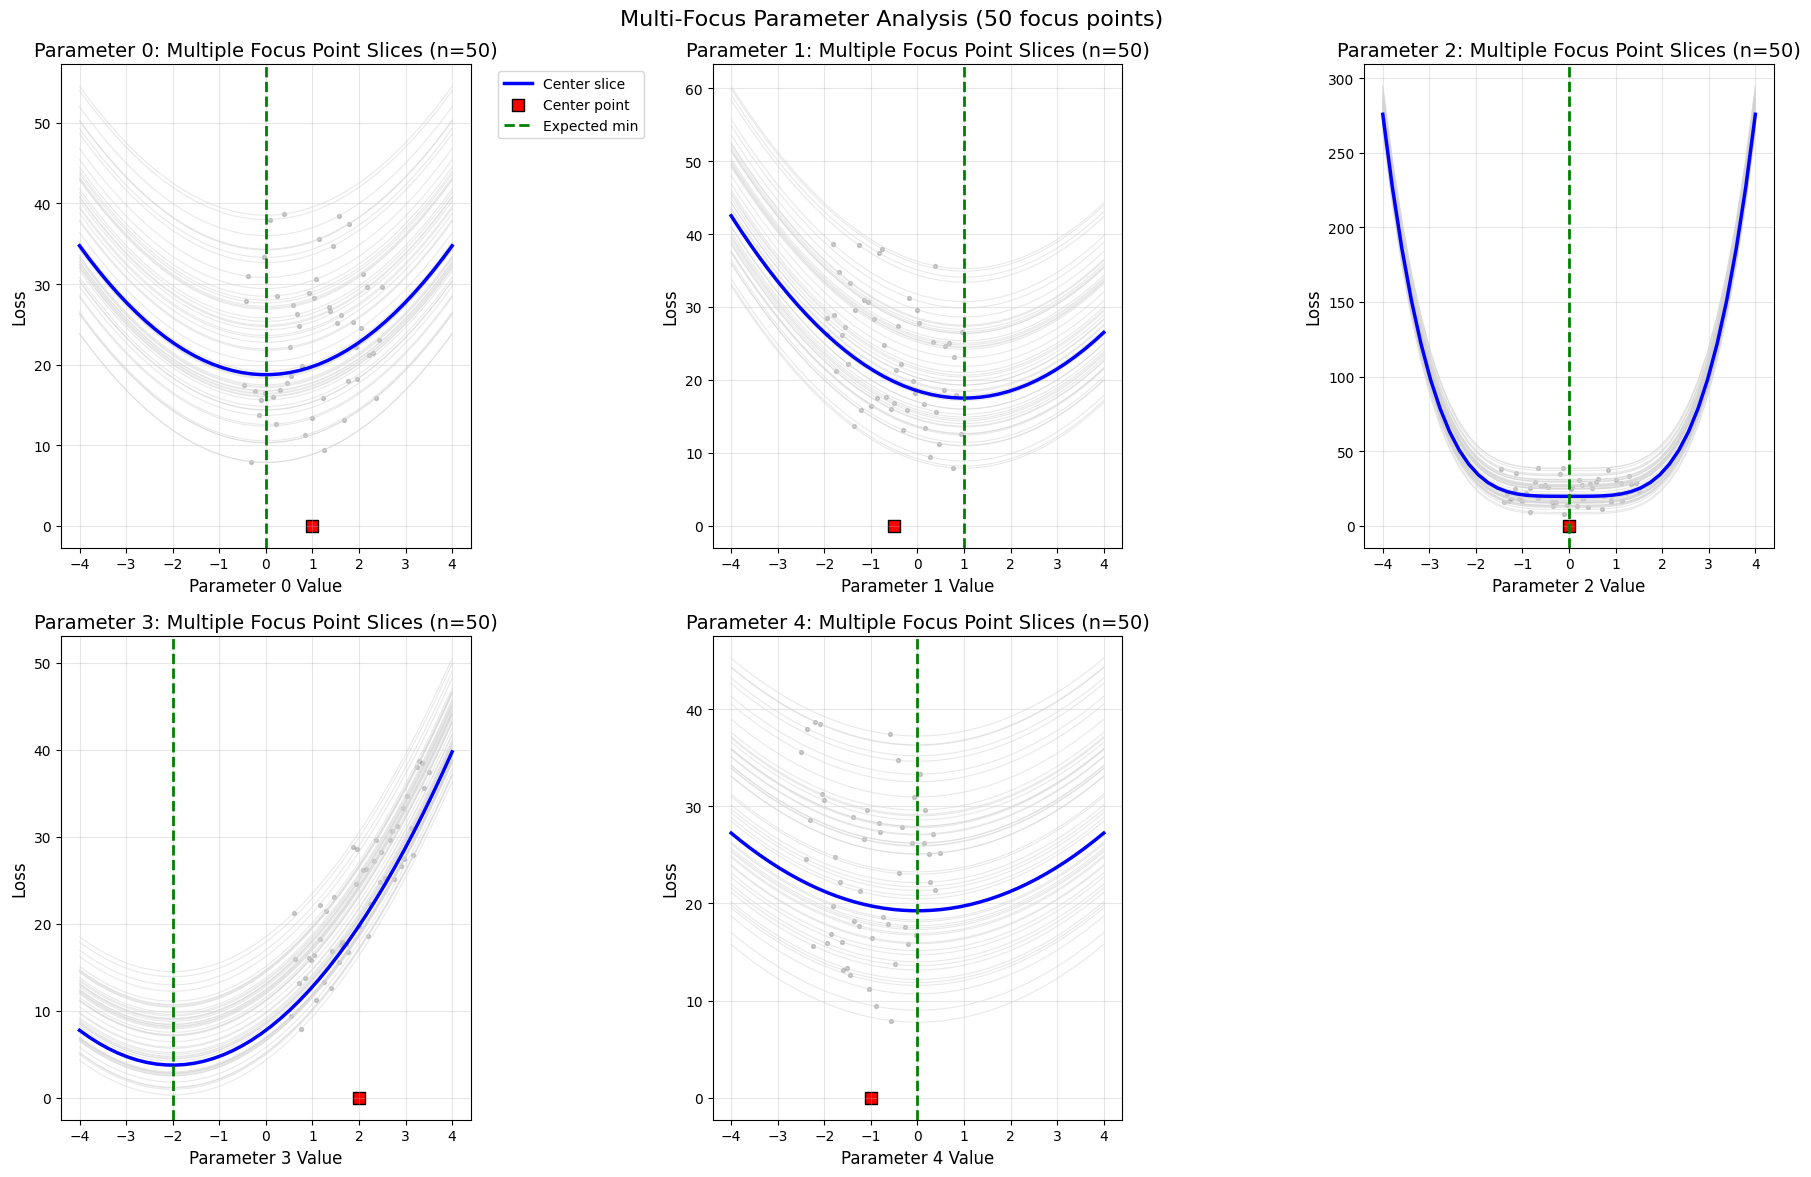

Shows 50 focus points with center slice highlighted
Center point: [ 1.  -0.5  0.   2.  -1. ] (loss: 19.7500)
Expected minima: [0.0, 1.0, 0.0, -2.0, 0.0]


In [46]:
# Demonstrate axis-parallel slicing with multiple focus points
axis_slicer = AxisParallelSlicer(model_wrapper_multi)

# Generate multiple focus points and slice around each one
focus_slice_data = axis_slicer.sample_focus_points_and_slice(
    center_point=None,  # Use current model parameters as center
    n_points=50,        # Generate 50 focus points for better coverage
    sampling_method="lhs",  # Latin Hypercube Sampling for good coverage
    radius=1.5,         # Sampling radius around center
    bounds=(-PARAM_RANGE, PARAM_RANGE),
    n_samples_per_slice=SLICING_STEPS,
    seed=42  # For reproducible results
)

# Extract results
center_point = focus_slice_data['center_point']
focus_points = focus_slice_data['focus_points']
focus_point_slices = focus_slice_data['focus_point_slices']
n_focus_points = len(focus_point_slices)

print(f"Focus point slicing completed!")
print(f"Center point: {center_point}")
print(f"Number of focus points: {n_focus_points}")
print(f"Sampling method: {focus_slice_data['sampling_method']}")
print(f"Sampling radius: {focus_slice_data['radius']}")

# Also generate a single slice from the center point for highlighting
center_slice_data = axis_slicer.slice(
    center_point=center_point,
    bounds=(-PARAM_RANGE, PARAM_RANGE),
    n_samples=SLICING_STEPS
)

# Create enhanced visualization using the new function
expected_minima = model_multi.get_expected_minima()

fig = plot_multi_focus_parameter_slices(
    slice_data=focus_slice_data,
    center_slice_data=center_slice_data,
    expected_minima=expected_minima,
    figsize=(18, 12),
    max_cols=3
)
plt.show()

print(f"Shows {n_focus_points} focus points with center slice highlighted")
print(f"Center point: {center_point} (loss: {model_wrapper_multi.compute_loss():.4f})")
print(f"Expected minima: {expected_minima}")

## 5. Random Direction Slicing: 2D Loss Landscapes

Random direction slicing explores the loss landscape along randomly chosen directions, providing 2D approximations of the loss landscape topology around a point in parameter space. This is accomplished by sampling two random direction vectors and computing loss on the plane they define.

In [47]:
# Create random direction slicer
random_slicer = RandomDirectionSlicer(model_wrapper_2d)

# Perform 2D random direction slicing
random_slice_data = random_slicer.slice(
    center_point=None,  # Use current model parameters
    n_samples=SLICING_STEPS,
    x_range=(-PARAM_RANGE, PARAM_RANGE),
    y_range=(-PARAM_RANGE, PARAM_RANGE),
    normalize_directions=True,
    ensure_orthogonal=True
)

# Extract 2D results
x_coords = random_slice_data['x_coordinates']
y_coords = random_slice_data['y_coordinates']
grid_data = random_slice_data['grid_data']
center_point_2d = random_slice_data['center_point']
direction1 = random_slice_data['direction1']
direction2 = random_slice_data['direction2']

print(f"Random direction slicing completed!")
print(f"Center point: [{center_point_2d[0]:.2f}, {center_point_2d[1]:.2f}]")
print(f"Direction 1: [{direction1[0]:.4f}, {direction1[1]:.4f}]")
print(f"Direction 2: [{direction2[0]:.4f}, {direction2[1]:.4f}]")
print(f"Orthogonality check (dot product): {np.dot(direction1, direction2):.8f}")

# Create mesh grid for plotting
X, Y = np.meshgrid(x_coords, y_coords)

Random direction slicing completed!
Center point: [0.20, 0.10]
Direction 1: [0.7365, 0.6765]
Direction 2: [-0.6765, 0.7365]
Orthogonality check (dot product): -0.00000000


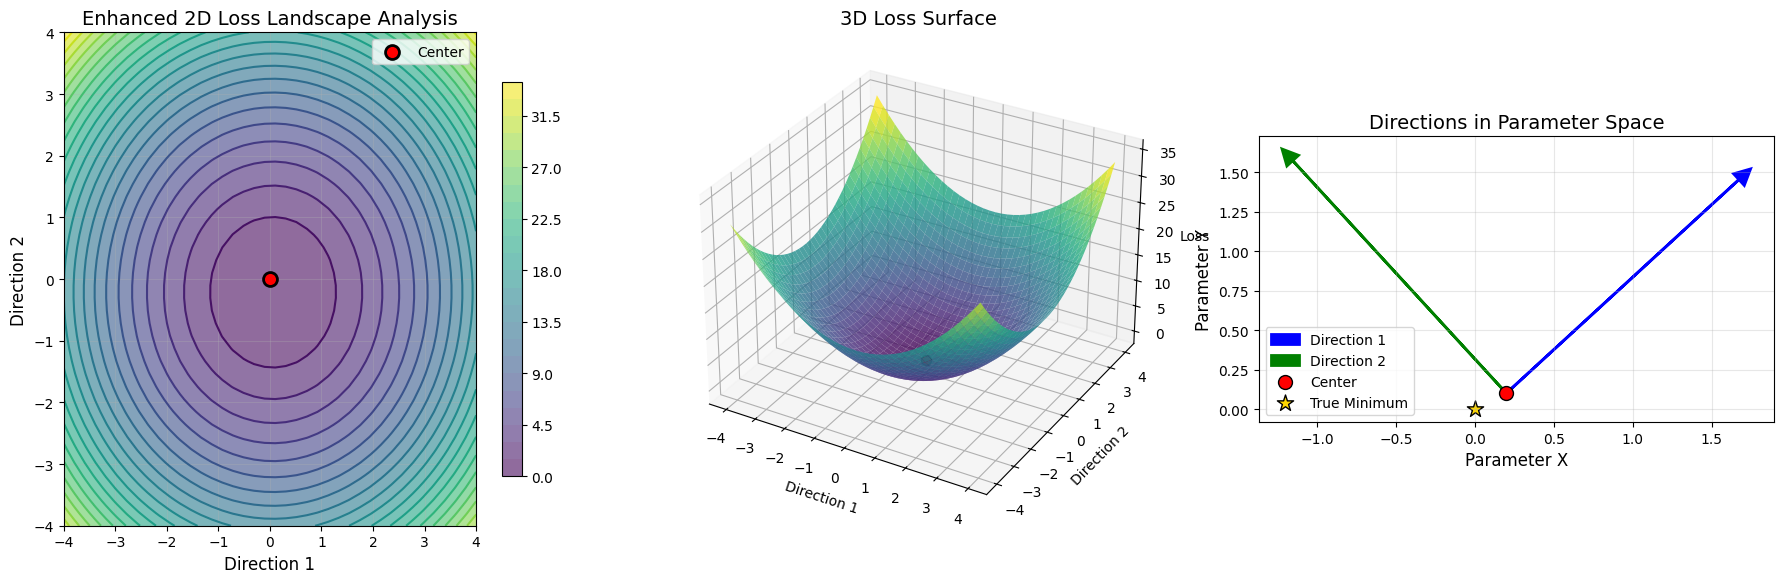

Random directions are orthogonal: -0.00000000


In [48]:
# Visualize the 2D loss landscape using enhanced visualization
fig = plot_2d_loss_landscape_enhanced(
    slice_data=random_slice_data,
    title="Enhanced 2D Loss Landscape Analysis",
    figsize=(18, 6),
    contour_levels=CONTOUR_LEVELS
)
plt.show()

print(f"Random directions are orthogonal: {np.dot(direction1, direction2):.8f}")

## 6. Neural Network Example: MNIST Classification

Now let's demonstrate PySlice on a real neural network trained on MNIST. This shows how the library works with actual machine learning models and realistic loss landscapes.

In [49]:
# Neural network hyperparameters
IN_DIM = 28 * 28
OUT_DIM = 10
LR = 10 ** -2
BATCH_SIZE = 512

class MLPSmall(torch.nn.Module):
    """ Small fully connected neural network for MNIST classification. """
    def __init__(self, x_dim, y_dim):
        super().__init__()
        self.linear_1 = torch.nn.Linear(x_dim, 32)
        self.linear_2 = torch.nn.Linear(32, y_dim)

    def forward(self, x):
        h = F.relu(self.linear_1(x))
        return F.log_softmax(self.linear_2(h), dim=1)  # Use log_softmax for NLLLoss

class Flatten(object):
    """ Transforms PIL image to flat numpy array. """
    def __call__(self, sample):
        return np.array(sample, dtype=np.float32).flatten() / 255.0  # Normalize

def train_model(model, optimizer, criterion, train_loader, epochs):
    """ Train the neural network. """
    model.train()
    for epoch in tqdm(range(epochs), desc='Training'):
        for batch_idx, (data, target) in enumerate(train_loader):
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            
            if batch_idx % 100 == 0:
                print(f'Epoch {epoch}, Batch {batch_idx}, Loss: {loss.item():.6f}')
    
    model.eval()

# Create dataset and model
print("Loading MNIST dataset...")
try:
    mnist_train = datasets.MNIST(root='../data', train=True, download=True, transform=Flatten())
    train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=BATCH_SIZE, shuffle=False)
    print("MNIST dataset loaded successfully!")
except:
    print("Could not load MNIST. Creating synthetic data for demonstration...")
    # Create synthetic data if MNIST fails to load
    synthetic_data = torch.randn(1000, IN_DIM)
    synthetic_targets = torch.randint(0, OUT_DIM, (1000,))
    train_loader = torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(synthetic_data, synthetic_targets),
        batch_size=BATCH_SIZE, shuffle=False
    )

# Define model
model_nn = MLPSmall(IN_DIM, OUT_DIM)
optimizer = optim.Adam(model_nn.parameters(), lr=LR)
criterion = torch.nn.NLLLoss()

print(f"Created neural network with {sum(p.numel() for p in model_nn.parameters())} parameters")

Loading MNIST dataset...
MNIST dataset loaded successfully!
Created neural network with 25450 parameters


In [50]:
# Store initial model state
model_nn_initial = copy.deepcopy(model_nn)

# Get a batch of data for loss evaluation
data_batch, target_batch = next(iter(train_loader))
print(f"Using batch of {data_batch.shape[0]} samples for loss evaluation")

# Create PySlice wrapper for the neural network
model_wrapper_nn = ModelWrapper(
    model=model_nn,
    loss_fn=criterion,
    train_data=(data_batch, target_batch)
)

initial_loss = model_wrapper_nn.compute_loss()
print(f"Initial loss: {initial_loss:.6f}")

# Train the model briefly
print("Training neural network...")
train_model(model_nn, optimizer, criterion, train_loader, epochs=5)  # Short training for demo

# Check final loss
final_loss = model_wrapper_nn.compute_loss()
print(f"Final loss: {final_loss:.6f}")
print(f"Loss reduction: {initial_loss - final_loss:.6f}")

# Store final model state
model_nn_final = copy.deepcopy(model_nn)

Using batch of 512 samples for loss evaluation
Initial loss: 2.311130
Training neural network...


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 0, Batch 0, Loss: 2.311130


Training:  20%|██        | 1/5 [00:01<00:04,  1.08s/it]

Epoch 0, Batch 100, Loss: 0.173415
Epoch 1, Batch 0, Loss: 0.191468


Training:  40%|████      | 2/5 [00:02<00:03,  1.08s/it]

Epoch 1, Batch 100, Loss: 0.143303
Epoch 2, Batch 0, Loss: 0.148070


Training:  60%|██████    | 3/5 [00:03<00:02,  1.08s/it]

Epoch 2, Batch 100, Loss: 0.113772
Epoch 3, Batch 0, Loss: 0.134373


Training:  80%|████████  | 4/5 [00:04<00:01,  1.10s/it]

Epoch 3, Batch 100, Loss: 0.096964
Epoch 4, Batch 0, Loss: 0.126796


Training: 100%|██████████| 5/5 [00:05<00:00,  1.09s/it]

Epoch 4, Batch 100, Loss: 0.086929
Final loss: 0.126118
Loss reduction: 2.185012


In [51]:
# Analyze the neural network's loss landscape using PySlice

# 1. Linear interpolation between initial and final states
print("Analyzing neural network loss landscape...")
nn_linear_slicer = LinearInterpolationSlicer(model_wrapper_nn)

# Get parameter vectors
initial_params = torch.nn.utils.parameters_to_vector(model_nn_initial.parameters()).detach().numpy()
final_params = model_wrapper_nn.get_parameters()

nn_slice_data = nn_linear_slicer.slice(
    start_point=initial_params,
    end_point=final_params,
    n_samples=30  # Smaller number for faster computation
)

nn_samples = nn_slice_data['samples']
nn_alphas = np.array([sample[0] for sample in nn_samples])
nn_losses = np.array([sample[1] for sample in nn_samples])

print(f"Linear interpolation: {len(nn_samples)} samples")
print(f"Loss range: {np.min(nn_losses):.6f} to {np.max(nn_losses):.6f}")

# 2. Random direction slice around final model
nn_random_slicer = RandomDirectionSlicer(model_wrapper_nn)

# Use smaller range and fewer samples for neural networks
nn_random_data = nn_random_slicer.slice(
    center_point=None,
    n_samples=20,  # Smaller grid for faster computation
    x_range=(-0.5, 0.5),  # Smaller range for neural networks
    y_range=(-0.5, 0.5),
    normalize_directions=True,
    ensure_orthogonal=True
)

nn_grid = nn_random_data['grid_data']
nn_x_coords = nn_random_data['x_coordinates']
nn_y_coords = nn_random_data['y_coordinates']

print(f"2D slice completed: {nn_grid.shape} grid")

Analyzing neural network loss landscape...
Linear interpolation: 30 samples
Loss range: 0.123476 to 3.653293
2D slice completed: (20, 20) grid


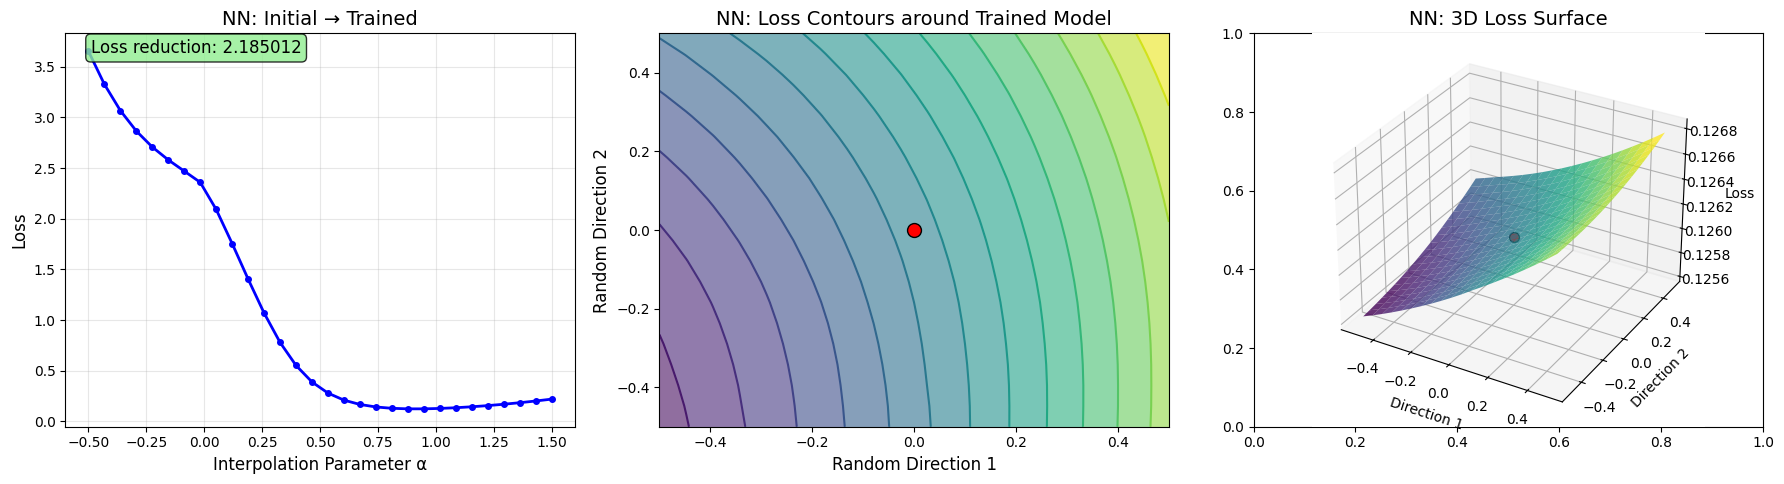

Loss reduction: 2.185012
Grid resolution: (20, 20)


In [52]:
# Plot neural network results using enhanced visualization
fig = plot_neural_network_analysis(
    linear_slice_data=nn_slice_data,
    random_slice_data=nn_random_data,
    initial_loss=initial_loss,
    final_loss=final_loss,
    figsize=(18, 5)
)
plt.show()

print(f"Loss reduction: {initial_loss - final_loss:.6f}")
print(f"Grid resolution: {nn_grid.shape}")